# Dataset analysis 

In [26]:
import numpy as np
import math
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from typing import List, Dict
import seaborn as sns
import json
from matplotlib import cm
from pprint import pformat
import json
import tikzplotlib


plt.style.use("seaborn")
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [27]:
def load_json(filename : str) -> Dict:
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

In [28]:
base_path_raw = r'/media/jan/DataStorage/ProjectData/temp/results_weighted_dataset_X_contrast_3'
base_path = [os.path.abspath(base_path_raw.replace('X', str(i))) for i in range(3)]

In [29]:
def get_results_frame(dim : int, csv_name = 'parameter_overview') -> pd.DataFrame:
    model_folders = [os.path.join(base_path[dim], o) for o in os.listdir(base_path[dim]) if os.path.isdir(os.path.join(base_path[dim],o)) and not o.startswith('.')]
    results = list()
    for folder in model_folders:
        try:
            r = load_json(os.path.join(folder, r'score_dict_final.json'))
        except:
            print(f'No experimant dict for folder {folder}.')
            continue
        exp_dict = load_json(os.path.join(folder, f'exp_dict.json'))
        r.update({
            'model_base' : exp_dict['model']['base'],
            'context_span' : exp_dict['dataset']['context_span'],
            'blob_points' : exp_dict['dataset']['blob_points'],
            'bg_points' : exp_dict['dataset']['bg_points'],
            'loss' : exp_dict['model']['loss'],
            'foldername' : folder.split('/')[-1],
            'sources' : exp_dict['dataset']['sources'],
            'separation_loss' : ('separation_loss' in exp_dict['model']['loss']),
            'prior_extend' : ('prior_extend' in exp_dict['model']['loss']),
            'weighted_point_loss' : ('rot_point_loss_multi_weighted' in exp_dict['model']['loss'])
        })
        results.append(r)

    results = pd.DataFrame(results).sort_values(['test_weighted_dice', 'test_dice'], ascending = False).reset_index(drop=True)
    results.to_csv(f'{csv_name}_dim{dim}')
    return results

In [30]:
results_dict = {dim : get_results_frame(dim) for dim in range(3)}
results_dict[0][['context_span', 'blob_points', 'bg_points', 'loss', 'separation_loss', 'weighted_point_loss', 'prior_extend', 'sources', 'test_weighted_dice', 'foldername']]

No experimant dict for folder /media/jan/DataStorage/ProjectData/temp/results_weighted_dataset_1_contrast_3/f877f00e3685efddf33a64d51d311dcb.
No experimant dict for folder /media/jan/DataStorage/ProjectData/temp/results_weighted_dataset_2_contrast_3/a38029e4d3d6d3c46092aa963ef04570.


,context_span,blob_points,bg_points,loss,separation_loss,weighted_point_loss,prior_extend,sources,test_weighted_dice,foldername
0,1,1,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM, PLoS]",0.625821,e5df8bf39051f574de84779e9b30c029_xVertSeg
1,1,1,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM, PLoS]",0.565390,e5df8bf39051f574de84779e9b30c029_PLoS
2,1,1,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM, PLoS]",0.559706,e5df8bf39051f574de84779e9b30c029_USiegen
3,1,3,10,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM, PLoS]",0.495984,28226d50e9b646704dd7b51c35de21d3
4,1,1,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM, PLoS]",0.475737,e5df8bf39051f574de84779e9b30c029
5,1,5,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM, PLoS]",0.470770,6126782960c8ebeb44c781ecade37ba1
6,1,3,10,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,True,True,"[xVertSeg, USiegen, MyoSegmenTUM, PLoS]",0.442121,77f85a6af05d76de63618ecb027b4210
7,1,1,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM, PLoS]",0.427556,e5df8bf39051f574de84779e9b30c029_MyoSegmenTUM
8,1,5,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",False,False,True,"[xVertSeg, USiegen, MyoSegmenTUM, PLoS]",0.359360,b498b1c4bb2a67d50083b0e0fafab75d
9,1,5,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,False,"[xVertSeg, USiegen, MyoSegmenTUM, PLoS]",0.317056,cbce367c887651d9c7baa1cf17defa60


In [31]:
results_dict[1][['context_span', 'blob_points', 'bg_points', 'loss', 'separation_loss', 'weighted_point_loss', 'prior_extend', 'sources', 'test_weighted_dice', 'foldername']]

,context_span,blob_points,bg_points,loss,separation_loss,weighted_point_loss,prior_extend,sources,test_weighted_dice,foldername
0,1,1,3,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.357091,6ef4aab564b17ec9748cd7e25f651d09_xVertSeg
1,1,1,3,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.342328,6ef4aab564b17ec9748cd7e25f651d09_MyoSegmenTUM
2,1,1,3,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.339489,6ef4aab564b17ec9748cd7e25f651d09
3,1,5,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.328977,7b8b7a23f8c8708146931117bac6ffda
4,5,5,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.295990,b8c6a17ee1dde24e0b4660954b64246a
5,1,7,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.289645,e924058886c7bf857f858db911a74908
6,1,5,3,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.288723,ace0b040af2185b7a0f5597fb628fc22
7,1,1,3,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.285559,6ef4aab564b17ec9748cd7e25f651d09_USiegen
8,1,7,3,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.277018,2c47333b1ea4c305ed0a3e23f12ee32f
9,1,5,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,True,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.123746,84dac37fa575a29e150a8a3aa16f3a90


In [32]:
results_dict[2][['context_span', 'blob_points', 'bg_points', 'loss', 'separation_loss', 'weighted_point_loss', 'prior_extend', 'sources', 'test_weighted_dice', 'foldername']]

,context_span,blob_points,bg_points,loss,separation_loss,weighted_point_loss,prior_extend,sources,test_weighted_dice,foldername
0,1,1,3,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.427247,6ef4aab564b17ec9748cd7e25f651d09_USiegen
1,1,1,3,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.353907,6ef4aab564b17ec9748cd7e25f651d09_MyoSegmenTUM
2,1,1,3,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.350211,6ef4aab564b17ec9748cd7e25f651d09
3,1,5,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.332808,7b8b7a23f8c8708146931117bac6ffda
4,1,7,3,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.332644,2c47333b1ea4c305ed0a3e23f12ee32f
5,5,5,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.329521,b8c6a17ee1dde24e0b4660954b64246a
6,1,5,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",False,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.325296,48ac69c67433af876745c307e2791c37
7,1,5,3,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.312020,ace0b040af2185b7a0f5597fb628fc22
8,1,7,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.305078,e924058886c7bf857f858db911a74908
9,1,1,3,"[unsupervised_rotation_loss, rot_point_loss_mu...",True,False,True,"[xVertSeg, USiegen, MyoSegmenTUM]",0.282290,6ef4aab564b17ec9748cd7e25f651d09_xVertSeg


investigate influence of leaving out a loss term

/home/jan/miniconda3/envs/thesis/lib/python3.8/site-packages/tikzplotlib/_hatches.py:65: UserWarning: tikzplotlib: Hatch '///' cannot be rendered. Only single character hatches are supported, e.g., {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}. Hatch '/' will be used.
  warnings.warn(


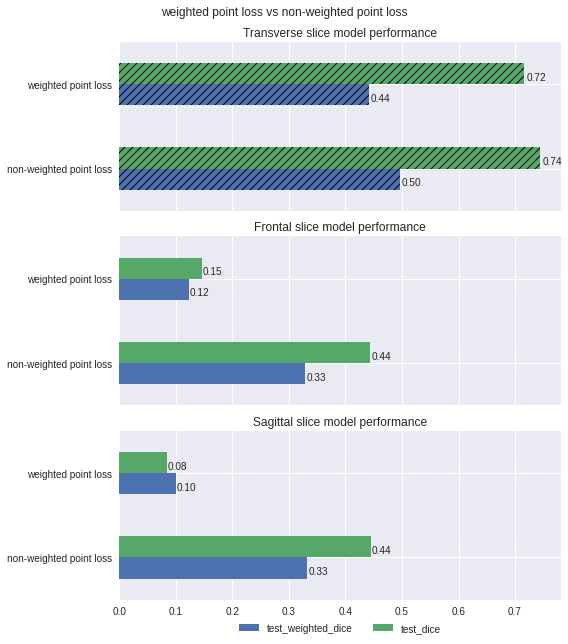

In [33]:
plt.figure(figsize=(8,9))
ax = plt.subplot(3,1,1)
res_select = results_dict[0].query('context_span == 1 & blob_points == 3 & bg_points == 10')
bars = res_select.plot.barh(x = 'weighted_point_loss', y = ['test_weighted_dice', 'test_dice'], ax=plt.gca(), legend=False, hatch = '///')
for p in bars.patches:
    ax.annotate(f'{p.get_width():0.2f}', ( p.get_width() * 1.005, p.get_y() + 0.05))
plt.title('Transverse slice model performance')
plt.yticks(ticks = [True, False], labels = ['weighted point loss', 'non-weighted point loss'])
plt.ylabel('')


plt.subplot(3,1,2, sharex = ax)
res_select = results_dict[1].query('context_span == 1 & blob_points == 5 & bg_points == 5')
bars = res_select.plot.barh(x = 'weighted_point_loss', y = ['test_weighted_dice', 'test_dice'], ax=plt.gca(), legend=False)
for p in bars.patches:
    plt.annotate(f'{p.get_width():0.2f}', ( p.get_width() * 1.005, p.get_y() + 0.05))
plt.title('Frontal slice model performance')
plt.yticks(ticks = [True, False], labels = ['weighted point loss', 'non-weighted point loss'])
plt.ylabel('')

plt.subplot(3,1,3, sharex = ax)
res_select = results_dict[2].query('context_span == 1 & blob_points == 5 & bg_points == 5 & separation_loss')
bars = res_select.plot.barh(x = 'weighted_point_loss', y = ['test_weighted_dice', 'test_dice'], ax=plt.gca())
for p in bars.patches:
    plt.annotate(f'{p.get_width():0.2f}', ( p.get_width() * 1.005, p.get_y() + 0.05))
plt.title('Sagittal slice model performance')
plt.yticks(ticks = [True, False], labels = ['weighted point loss', 'non-weighted point loss'])
plt.ylabel('')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25),
          ncol=2)

plt.suptitle('weighted point loss vs non-weighted point loss')
plt.tight_layout()

plt.savefig('weightedvsnonweighted.png')
tikzplotlib.save('weightedvsnonweighted.tex', axis_width ='8cm', axis_height ='9cm')

/home/jan/miniconda3/envs/thesis/lib/python3.8/site-packages/tikzplotlib/_hatches.py:65: UserWarning: tikzplotlib: Hatch '///' cannot be rendered. Only single character hatches are supported, e.g., {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}. Hatch '/' will be used.
  warnings.warn(


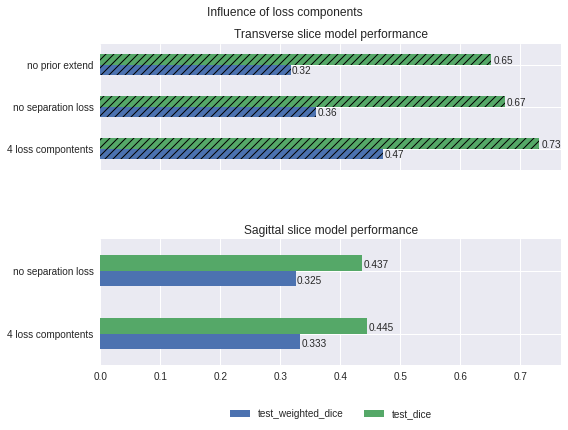

In [34]:
plt.figure(figsize=(8,8))
ax = plt.subplot(3,1,1)
res_select = results_dict[0].query('context_span == 1 & blob_points == 5 & bg_points == 5')
bars = res_select.plot.barh(x = 'loss', y = ['test_weighted_dice', 'test_dice'], ax=plt.gca(), legend=False, hatch = '///')
for p in bars.patches:
    ax.annotate(f'{p.get_width():0.2f}', ( p.get_width() * 1.005, p.get_y() + 0.03))
plt.title('Transverse slice model performance')
plt.yticks(ticks = [2, 1, 0], labels = ['no prior extend', 'no separation loss', '4 loss compontents'])
plt.ylabel('')

plt.subplot(3,1,2, sharex = ax)
res_select = results_dict[2].query('context_span == 1 & blob_points == 5 & bg_points == 5 & not weighted_point_loss')
bars = res_select.plot.barh(x = 'loss', y = ['test_weighted_dice', 'test_dice'], ax=plt.gca())
for p in bars.patches:
    plt.annotate(f'{p.get_width():0.3f}', ( p.get_width() * 1.005, p.get_y() + 0.05))
plt.title('Sagittal slice model performance')
plt.yticks(ticks = [1, 0], labels = ['no separation loss', '4 loss compontents'])
plt.ylabel('')

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.50),
          ncol=2)

plt.suptitle('Influence of loss components')
plt.tight_layout()

plt.savefig('Losscomponents.png')
tikzplotlib.save('Losscomponents.tex', axis_width ='8cm', axis_height ='8cm')

In [35]:
res_select = results_dict[1].query('context_span == 1 & weighted_point_loss == False & separation_loss')
res_select = res_select[-res_select.foldername.str.contains('_')]
res_1 = res_select.pivot(index = 'blob_points', columns = 'bg_points', values = 'test_weighted_dice')
res_select = results_dict[2].query('context_span == 1 & weighted_point_loss == False & separation_loss')

res_select = res_select[-res_select.foldername.str.contains('_')]

res_2 = res_select.pivot(index = 'blob_points', columns = 'bg_points', values = 'test_weighted_dice')

res_select

,train_score,train_weighted_dice,train_dice,train_loss,epoch,waiting,val_score,val_weighted_dice,val_dice,test_dice,...,model_base,context_span,blob_points,bg_points,loss,foldername,sources,separation_loss,prior_extend,weighted_point_loss
2,0.409622,0.409622,0.495781,-8.425481,1,4,0.377342,0.377342,0.470773,0.458656,...,fcn8_vgg16,1,1,3,"[unsupervised_rotation_loss, rot_point_loss_mu...",6ef4aab564b17ec9748cd7e25f651d09,"[xVertSeg, USiegen, MyoSegmenTUM]",True,True,False
3,0.389227,0.389227,0.481686,-8.409649,2,4,0.360313,0.360313,0.458403,0.444835,...,fcn8_vgg16,1,5,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",7b8b7a23f8c8708146931117bac6ffda,"[xVertSeg, USiegen, MyoSegmenTUM]",True,True,False
4,0.378288,0.378288,0.473831,-8.436708,12,4,0.352975,0.352975,0.453290,0.443631,...,fcn8_vgg16,1,7,3,"[unsupervised_rotation_loss, rot_point_loss_mu...",2c47333b1ea4c305ed0a3e23f12ee32f,"[xVertSeg, USiegen, MyoSegmenTUM]",True,True,False
7,0.369492,0.369492,0.413946,-8.288434,18,4,0.332472,0.332472,0.389681,0.426807,...,fcn8_vgg16,1,5,3,"[unsupervised_rotation_loss, rot_point_loss_mu...",ace0b040af2185b7a0f5597fb628fc22,"[xVertSeg, USiegen, MyoSegmenTUM]",True,True,False
8,0.358730,0.358730,0.446945,-8.297664,18,4,0.325814,0.325814,0.422322,0.419827,...,fcn8_vgg16,1,7,5,"[unsupervised_rotation_loss, rot_point_loss_mu...",e924058886c7bf857f858db911a74908,"[xVertSeg, USiegen, MyoSegmenTUM]",True,True,False


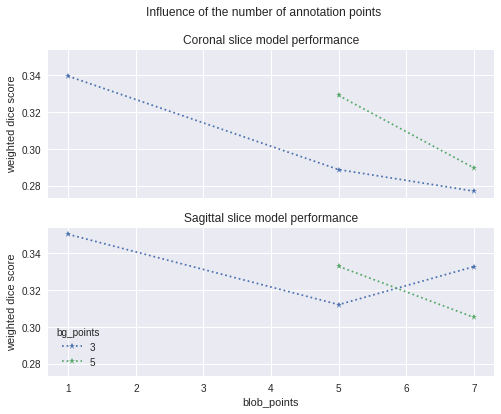

In [36]:
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
ax = res_1.plot(ax = plt.gca(), legend=False, linestyle = ':', marker = '*')
plt.xlabel('weighted dice score')
plt.title('Coronal slice model performance')
ax.set_ylabel("weighted dice score")
plt.subplot(2,1,2, sharex = ax, sharey = ax)
ax = res_2.plot(ax = plt.gca(), linestyle = ':', marker = '*')
plt.title('Sagittal slice model performance')
ax.set_ylabel("weighted dice score")

plt.suptitle('Influence of the number of annotation points')

plt.savefig('BlobPoints_influence.png')
tikzplotlib.save('BlobPoints_influence.tex', axis_width ='8cm', axis_height ='6cm')

In [37]:
reconstruct_foldernames = []

res_select = results_dict[0].query('context_span == 1 & weighted_point_loss == False & separation_loss & blob_points == 1')
res_select = res_select[-res_select.foldername.str.contains('_')]
print(res_select[['foldername', 'test_weighted_dice']])
reconstruct_foldernames.append(res_select.foldername.iloc[0])
res_select = results_dict[1].query('context_span == 1 & weighted_point_loss == False & separation_loss & bg_points == 3 & blob_points == 1')
res_select = res_select[-res_select.foldername.str.contains('_')]
print(res_select[['foldername', 'test_weighted_dice']])
reconstruct_foldernames.append(res_select.foldername.iloc[0])
res_select = results_dict[2].query('context_span == 1 & weighted_point_loss == False & separation_loss & bg_points == 3 & blob_points == 1')
res_select = res_select[-res_select.foldername.str.contains('_')]
print(res_select[['foldername', 'test_weighted_dice']])
reconstruct_foldernames.append(res_select.foldername.iloc[0])


exp_dict_reconstruct = dict()
for i, foldername in enumerate(reconstruct_foldernames):
    folder = os.path.join(base_path[i], foldername)
    print(folder)
    exp_dict = load_json(os.path.join(folder, f'exp_dict.json'))
    exp_dict['hash'] = foldername
    exp_dict_reconstruct[i] = exp_dict

with open('exp_dict_reconstruct.json', 'w') as f:
    json.dump(exp_dict_reconstruct, f)
    

                         foldername  test_weighted_dice
4  e5df8bf39051f574de84779e9b30c029            0.475737
                         foldername  test_weighted_dice
2  6ef4aab564b17ec9748cd7e25f651d09            0.339489
                         foldername  test_weighted_dice
2  6ef4aab564b17ec9748cd7e25f651d09            0.350211
/media/jan/DataStorage/ProjectData/temp/results_weighted_dataset_0_contrast_3/e5df8bf39051f574de84779e9b30c029
/media/jan/DataStorage/ProjectData/temp/results_weighted_dataset_1_contrast_3/6ef4aab564b17ec9748cd7e25f651d09
/media/jan/DataStorage/ProjectData/temp/results_weighted_dataset_2_contrast_3/6ef4aab564b17ec9748cd7e25f651d09


In [38]:
res_select.foldername.iloc[0]

'6ef4aab564b17ec9748cd7e25f651d09'

# Fully supervised models

In [39]:
base_path_raw = r'/media/jan/DataStorage/ProjectData/temp/results_full_dataset_X_contrast_3'
base_path = [os.path.abspath(base_path_raw.replace('X', str(i))) for i in range(3)]
def get_results_frame(dim : int, csv_name = 'parameter_overview') -> pd.DataFrame:
    model_folders = [os.path.join(base_path[dim], o) for o in os.listdir(base_path[dim]) if os.path.isdir(os.path.join(base_path[dim],o)) and not o.startswith('.')]
    results = list()
    for folder in model_folders:
        try:
            r = load_json(os.path.join(folder, r'score_dict_final.json'))
        except:
            print(f'No experimant dict for folder {folder}.')
            continue
        exp_dict = load_json(os.path.join(folder, f'exp_dict.json'))
        r.update({
            'model_base' : exp_dict['model']['base'],
            'context_span' : exp_dict['dataset']['context_span'],
            'blob_points' : exp_dict['dataset']['blob_points'],
            'bg_points' : exp_dict['dataset']['bg_points'],
            'loss' : exp_dict['model']['loss'],
            'foldername' : folder.split('/')[-1],
            'sources' : exp_dict['dataset']['sources'],
            'separation_loss' : ('separation_loss' in exp_dict['model']['loss']),
            'prior_extend' : ('prior_extend' in exp_dict['model']['loss']),
            'weighted_point_loss' : ('rot_point_loss_multi_weighted' in exp_dict['model']['loss'])
        })
        results.append(r)

    results = pd.DataFrame(results).sort_values(['test_weighted_dice', 'test_dice'], ascending = False).reset_index(drop=True)
    results.to_csv(f'{csv_name}_dim{dim}')
    return results

results_dict = {dim : get_results_frame(dim) for dim in range(1,3)}
results_dict[2][['context_span', 'blob_points', 'bg_points', 'loss', 'separation_loss', 'weighted_point_loss', 'prior_extend', 'sources', 'test_weighted_dice', 'foldername']]

No experimant dict for folder /media/jan/DataStorage/ProjectData/temp/results_full_dataset_1_contrast_3/ab60e3fb01ac94277d5b75f445473d42.


,context_span,blob_points,bg_points,loss,separation_loss,weighted_point_loss,prior_extend,sources,test_weighted_dice,foldername
0,0,1,-1,cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.758672,edc036f241e350ed66b07d6edebaaef2
1,1,1,-1,cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.752692,dfaeaf1bd9747b2b0d135fd495f699ec
2,3,1,-1,cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.744971,b1292d31b739d2327982349d5f6b27e8
3,1,1,-1,weighted_cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.743244,365ae50c5f1f0a7320a2db9e99cd5cc8
4,3,1,-1,weighted_cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.739865,26aa087080bfa4fb5a6602d6fda8757d
5,1,1,-1,cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.719089,3ce60ea3c13d67ff7334beb1be210603
6,1,1,-1,cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.713119,6ab04a2154becb82b23e49700c9d2396
7,3,1,-1,cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.712101,4c21df3fe5f18164f1123cbd03edea2b
8,0,1,-1,weighted_cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.706862,16ad1271ac0f9f11c79a6d9e2b3cd8a4
9,0,1,-1,cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.702805,309402cd6123961fdd1a827faafdea05


In [40]:
res_select = results_dict[2][-results_dict[2].foldername.str.contains('_')]

loss         cross_entropy                   weighted_cross_entropy  \
model_base     fcn8_resnet fcn8_vgg16 unet2d            fcn8_resnet   
context_span                                                          
0                     0.67       0.76   0.70                   0.62   
1                     0.72       0.75   0.71                   0.66   
3                     0.71       0.74   0.65                   0.62   
0                     0.73       0.80   0.75                   0.68   
1                     0.77       0.80   0.76                   0.71   
3                     0.77       0.79   0.70                   0.69   

loss                            
model_base   fcn8_vgg16 unet2d  
context_span                    
0                  0.63   0.71  
1                  0.74   0.66  
3                  0.74   0.65  
0                  0.70   0.76  
1                  0.79   0.72  
3                  0.78   0.71

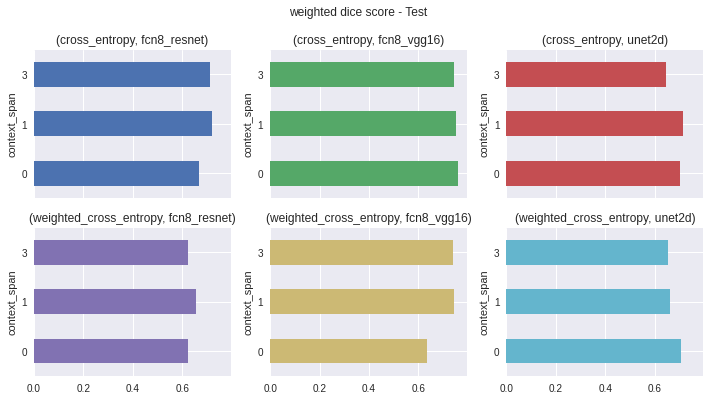

In [41]:
test_wd = res_select.pivot(index = 'context_span', columns = ['loss', 'model_base'], values = 'test_weighted_dice')
test_d = res_select.pivot(index = 'context_span', columns = ['loss', 'model_base'], values = 'test_dice')

test_wd = test_wd.reindex(sorted(test_wd.columns), axis=1)

test_wd.applymap(lambda x : round(x, 2)).to_html('test_wd.html')
test_wd.plot.barh(subplots = True, layout = (2, 3), legend = False, figsize = (12, 6), sharex = True)
plt.suptitle('weighted dice score - Test')
plt.savefig('full_test_wd.png')

pd.concat([test_wd, test_d], axis=0).applymap(lambda x : round(x, 2))

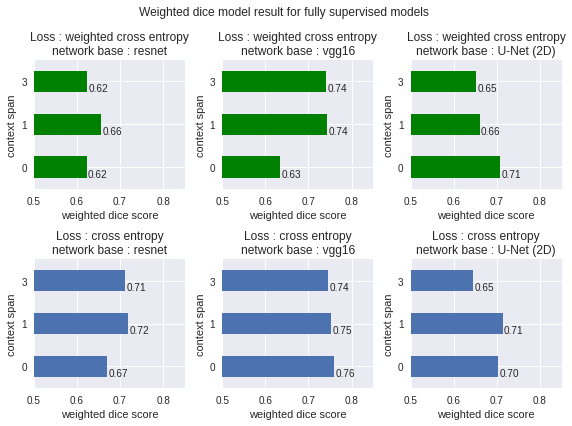

In [42]:
plt.figure(figsize=(8,6))

for i, n in enumerate(zip(['fcn8_resnet', 'fcn8_vgg16', 'unet2d'], ['resnet', 'vgg16', 'U-Net (2D)'])):
    netw, netw_name = n
    ax = plt.subplot(2,3,i+1)
    s = test_wd.loc[:, ('weighted_cross_entropy', netw)]
    bars = s.plot.barh(ax = plt.gca(), legend=False, color = 'g')
    for p in bars.patches:
        ax.annotate(f'{p.get_width():0.2f}', ( p.get_width() * 1.005, p.get_y() + 0.03))
    plt.xlabel('weighted dice score')
    plt.ylabel('context span')
    plt.xlim(0.5,0.85)
    plt.title(f'Loss : weighted cross entropy\nnetwork base : {netw_name}')

for i, n in enumerate(zip(['fcn8_resnet', 'fcn8_vgg16', 'unet2d'], ['resnet', 'vgg16', 'U-Net (2D)'])):
    netw, netw_name = n
    ax = plt.subplot(2,3,i+4)
    s = test_wd.loc[:, ('cross_entropy', netw)]
    bars = s.plot.barh(ax = plt.gca(), legend=False)
    for p in bars.patches:
        ax.annotate(f'{p.get_width():0.2f}', ( p.get_width() * 1.005, p.get_y() + 0.03))
    plt.xlabel('weighted dice score')
    plt.ylabel('context span')
    plt.xlim(0.5,0.85)
    plt.title(f'Loss : cross entropy\nnetwork base : {netw_name}')

plt.suptitle('Weighted dice model result for fully supervised models')
plt.tight_layout()

plt.savefig('FullySupervised.png')


365ae50c5f1f0a7320a2db9e99cd5cc8


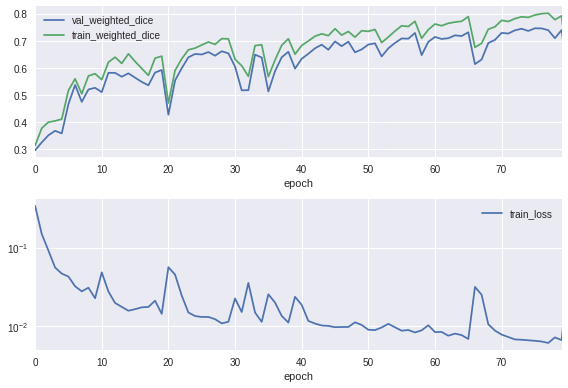

In [43]:
foldername = results_dict[2].query("context_span == 1 & loss == 'weighted_cross_entropy' & model_base == 'fcn8_vgg16'").foldername.iloc[0]
print(foldername)
score_df = pd.read_csv(os.path.join(base_path[2], foldername, 'score_df.csv'), index_col=0)

f, ax = plt.subplots(2)
score_df.plot(x = 'epoch', y = 'val_weighted_dice', ax = ax[0], xlim = [0,79])
score_df.plot(x = 'epoch', y = 'train_weighted_dice', ax = ax[0], xlim = [0,79])
score_df.plot(x = 'epoch', y = 'train_loss', ax=ax[1], logy = True, xlim = [0,79])

plt.tight_layout()
plt.savefig('full_learning_curve.png')



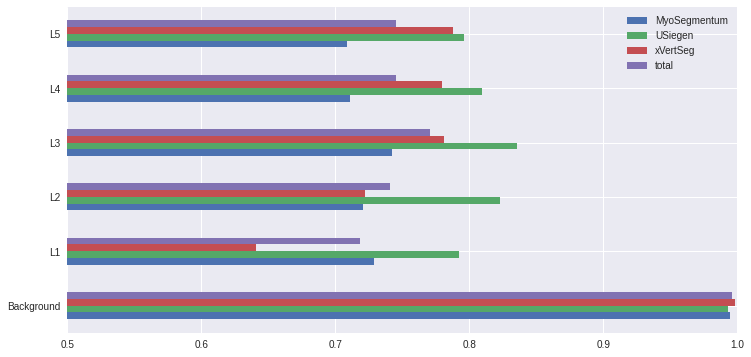

In [44]:
Myo_df = pd.read_csv(os.path.join(base_path[2], foldername, 'test_metrics_MyoSegmenTUM_df.csv'), index_col=0)
USieg_df = pd.read_csv(os.path.join(base_path[2], foldername, 'test_metrics_USiegen_df.csv'), index_col=0)
xVert_df = pd.read_csv(os.path.join(base_path[2], foldername, 'test_metrics_xVertSeg_df.csv'), index_col=0)
all_df = pd.read_csv(os.path.join(base_path[2], foldername, 'test_metrics_df.csv'), index_col=0)

temp = pd.DataFrame()
for name, df in zip(['MyoSegmentum', 'USiegen', 'xVertSeg', 'total'], [Myo_df, USieg_df, xVert_df, all_df]):
    temp[name] = df['dice']

temp.plot(kind = 'barh', xlim = (.5, 1), figsize=(12, 6))
plt.savefig('full_perSource.png')

In [45]:
base_path_raw = r'/media/jan/DataStorage/ProjectData/temp/results_weighted_dataset_X_contrast_3'
base_path = [os.path.abspath(base_path_raw.replace('X', str(i))) for i in range(3)]
folders = []
for bp in base_path:
    model_folders = [os.path.join(bp, o) for o in os.listdir(bp) if os.path.isdir(os.path.join(bp,o)) and not o.startswith('.')]
    folders.append(model_folders[0])

folders

['/media/jan/DataStorage/ProjectData/temp/results_weighted_dataset_0_contrast_3/cbce367c887651d9c7baa1cf17defa60',
 '/media/jan/DataStorage/ProjectData/temp/results_weighted_dataset_1_contrast_3/2c47333b1ea4c305ed0a3e23f12ee32f',
 '/media/jan/DataStorage/ProjectData/temp/results_weighted_dataset_2_contrast_3/2c47333b1ea4c305ed0a3e23f12ee32f']

In [46]:
result = []
for i in range(3):
    r = load_json(os.path.join(folders[i], r'score_dict_final.json'))
    exp_dict = load_json(os.path.join(folders[i], f'exp_dict.json'))
    r.update({
            'model_base' : exp_dict['model']['base'],
            'context_span' : exp_dict['dataset']['context_span'],
            'loss' : exp_dict['model']['loss'],
            'foldername' : folder.split('/')[-1],
            'dim' : i
        })
    result.append(r)

result = pd.DataFrame(result).sort_values(['test_weighted_dice', 'test_dice'], ascending = False)
result

,train_score,train_weighted_dice,train_dice,train_loss,epoch,waiting,val_score,val_weighted_dice,val_dice,test_dice,test_weighted_dice,test_iou,test_prec,test_recall,test_score,model_base,context_span,loss,foldername,dim
2,0.378288,0.378288,0.473831,-8.436708,12,4,0.352975,0.352975,0.453290,0.443631,0.332644,0.330575,0.854151,0.345325,0.332644,fcn8_vgg16,1,"[unsupervised_rotation_loss, rot_point_loss_mu...",6ef4aab564b17ec9748cd7e25f651d09,2
0,0.330339,0.330339,0.658029,-0.971247,15,5,0.325522,0.325522,0.653973,0.651150,0.317056,0.581812,0.983286,0.593142,0.317056,fcn8_vgg16,1,"[unsupervised_rotation_loss, rot_point_loss_mu...",6ef4aab564b17ec9748cd7e25f651d09,0
1,0.333478,0.333478,0.399650,-8.545348,16,4,0.303144,0.303144,0.378618,0.399060,0.277018,0.302831,0.859376,0.313489,0.277018,fcn8_vgg16,1,"[unsupervised_rotation_loss, rot_point_loss_mu...",6ef4aab564b17ec9748cd7e25f651d09,1


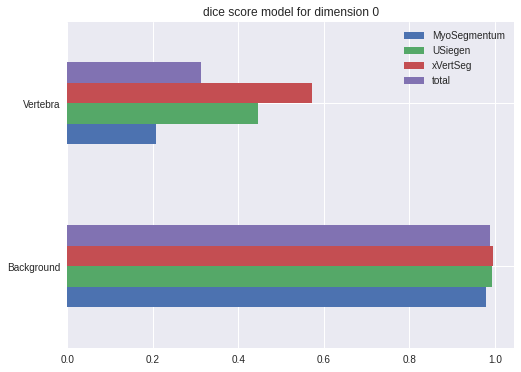

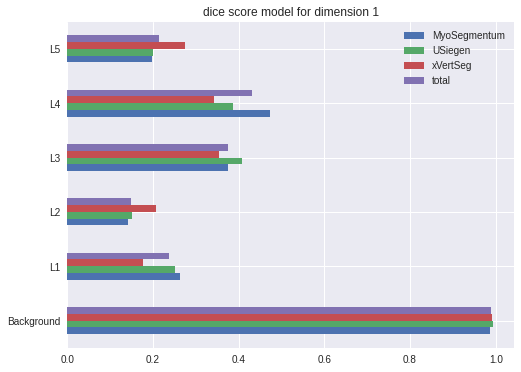

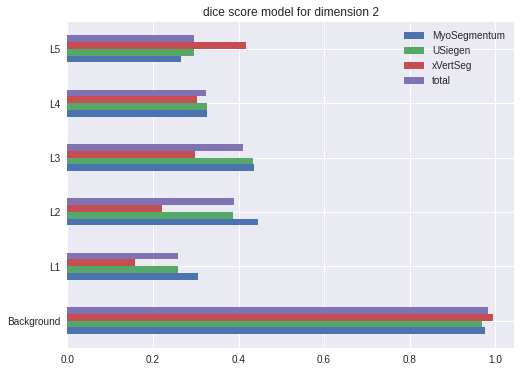

In [47]:
for i in range(3):
    Myo_df = pd.read_csv(os.path.join(folders[i], 'test_metrics_MyoSegmenTUM_df.csv'), index_col=0)
    USieg_df = pd.read_csv(os.path.join(folders[i], 'test_metrics_USiegen_df.csv'), index_col=0)
    xVert_df = pd.read_csv(os.path.join(folders[i], 'test_metrics_xVertSeg_df.csv'), index_col=0)
    all_df = pd.read_csv(os.path.join(folders[i], 'test_metrics_df.csv'), index_col=0)

    temp = pd.DataFrame()
    for name, df in zip(['MyoSegmentum', 'USiegen', 'xVertSeg', 'total'], [Myo_df, USieg_df, xVert_df, all_df]):
        temp[name] = df['dice']

    temp.plot(kind = 'barh', figsize=(8, 6), title=f'dice score model for dimension {i}')
    plt.savefig(f'dim_{i}_perSource.png')

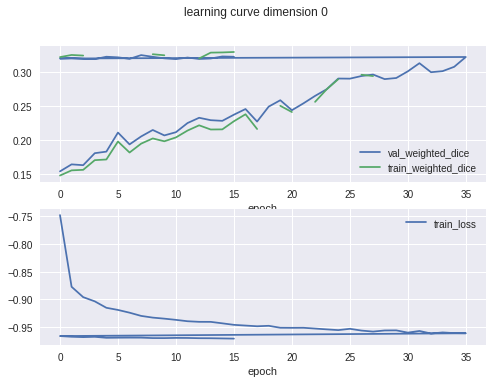

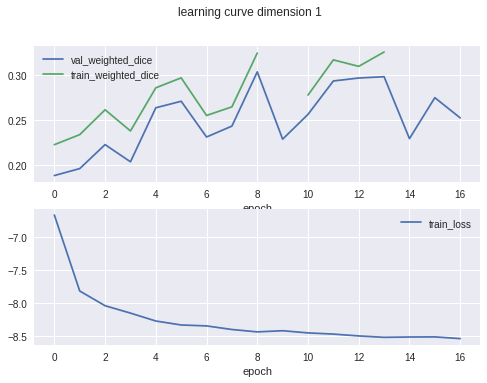

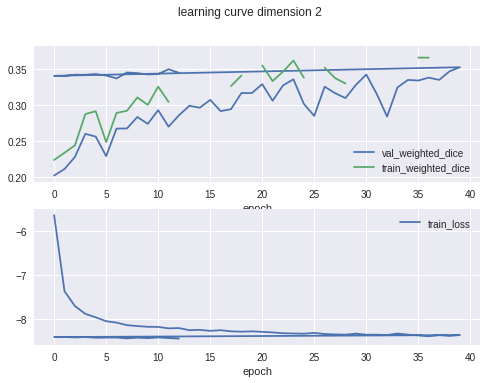

In [48]:
for i in range(3):
    score_df = pd.read_csv(os.path.join(folders[i], 'score_df.csv'), index_col=0)

    f, ax = plt.subplots(2)
    score_df.plot(x = 'epoch', y = 'val_weighted_dice', ax = ax[0])
    score_df.plot(x = 'epoch', y = 'train_weighted_dice', ax = ax[0])
    score_df.plot(x = 'epoch', y = 'train_loss', ax=ax[1], logy = False)
    plt.suptitle(f'learning curve dimension {i}')

    plt.savefig(f'weakly_dim{i}_learning_curve.png')

In [50]:
base_path_raw = r'/media/jan/DataStorage/ProjectData/temp/results_full_dataset_2_specific'
base_path = [os.path.abspath(base_path_raw.replace('X', str(i))) for i in range(3)]
def get_results_frame(dim : int, csv_name = 'parameter_overview') -> pd.DataFrame:
    model_folders = [os.path.join(base_path[dim], o) for o in os.listdir(base_path[dim]) if os.path.isdir(os.path.join(base_path[dim],o)) and not o.startswith('.')]
    results = list()
    for folder in model_folders:
        try:
            r = load_json(os.path.join(folder, r'score_dict_final.json'))
        except:
            print(f'No experimant dict for folder {folder}.')
            continue
        exp_dict = load_json(os.path.join(folder, f'exp_dict.json'))
        r.update({
            'model_base' : exp_dict['model']['base'],
            'context_span' : exp_dict['dataset']['context_span'],
            'blob_points' : exp_dict['dataset']['blob_points'],
            'bg_points' : exp_dict['dataset']['bg_points'],
            'loss' : exp_dict['model']['loss'],
            'foldername' : folder.split('/')[-1],
            'sources' : exp_dict['dataset']['sources'],
            'separation_loss' : ('separation_loss' in exp_dict['model']['loss']),
            'prior_extend' : ('prior_extend' in exp_dict['model']['loss']),
            'weighted_point_loss' : ('rot_point_loss_multi_weighted' in exp_dict['model']['loss'])
        })
        results.append(r)

    results = pd.DataFrame(results).sort_values(['test_weighted_dice', 'test_dice'], ascending = False).reset_index(drop=True)
    results.to_csv(f'{csv_name}_dim{dim}')
    return results

res_select = get_results_frame(2) 
res_select[['context_span', 'blob_points', 'bg_points', 'loss', 'separation_loss', 'weighted_point_loss', 'prior_extend', 'sources', 'test_weighted_dice', 'foldername']]

No experimant dict for folder /media/jan/DataStorage/ProjectData/temp/results_full_dataset_2_specific/code.


,context_span,blob_points,bg_points,loss,separation_loss,weighted_point_loss,prior_extend,sources,test_weighted_dice,foldername
0,3,1,-1,cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.723208,b1292d31b739d2327982349d5f6b27e8
1,1,1,-1,cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.710537,dfaeaf1bd9747b2b0d135fd495f699ec
2,0,1,-1,cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.688176,edc036f241e350ed66b07d6edebaaef2
3,3,1,-1,weighted_cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.652637,26aa087080bfa4fb5a6602d6fda8757d
4,0,1,-1,weighted_cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.650607,ab60e3fb01ac94277d5b75f445473d42
5,1,1,-1,weighted_cross_entropy,False,False,False,"[xVertSeg, USiegen, MyoSegmenTUM]",0.613261,365ae50c5f1f0a7320a2db9e99cd5cc8


In [54]:
res_select.columns

Index(['train_score', 'train_weighted_dice', 'train_dice', 'train_loss',
       'epoch', 'waiting', 'val_score', 'val_weighted_dice', 'val_dice',
       'test_dice', 'test_weighted_dice', 'test_iou', 'test_prec',
       'test_recall', 'test_score', 'model_base', 'context_span',
       'blob_points', 'bg_points', 'loss', 'foldername', 'sources',
       'separation_loss', 'prior_extend', 'weighted_point_loss'],
      dtype='object')

loss,cross_entropy,weighted_cross_entropy
model_base,fcn8_vgg16,fcn8_vgg16
context_span,,
0,0.69,0.65
1,0.71,0.61
3,0.72,0.65
0,0.73,0.83
1,0.74,0.86
3,0.75,0.83


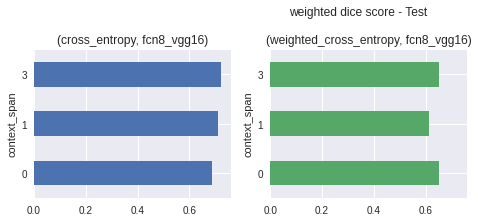

In [55]:
test_wd = res_select.pivot(index = 'context_span', columns = ['loss', 'model_base'], values = 'test_weighted_dice')
test_d = res_select.pivot(index = 'context_span', columns = ['loss', 'model_base'], values = 'test_prec')

test_wd = test_wd.reindex(sorted(test_wd.columns), axis=1)

test_wd.applymap(lambda x : round(x, 2)).to_html('test_wd.html')
test_wd.plot.barh(subplots = True, layout = (2, 3), legend = False, figsize = (12, 6), sharex = True)
plt.suptitle('weighted dice score - Test')
plt.savefig('full_test_wd.png')

pd.concat([test_wd, test_d], axis=0).applymap(lambda x : round(x, 2))

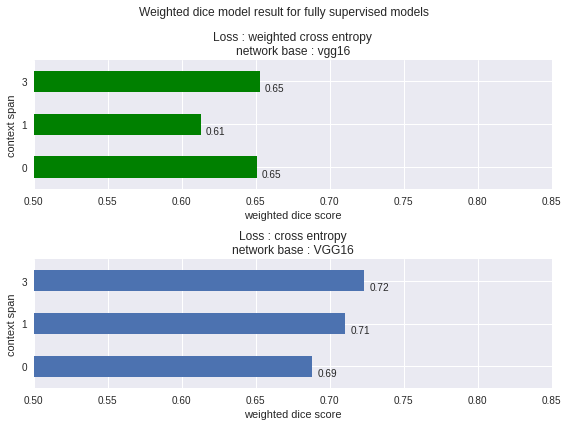

In [58]:
plt.figure(figsize=(8,6))


ax = plt.subplot(2,1,1)
s = test_wd.loc[:, ('weighted_cross_entropy', 'fcn8_vgg16')]
bars = s.plot.barh(ax = plt.gca(), legend=False, color = 'g')
for p in bars.patches:
    ax.annotate(f'{p.get_width():0.2f}', ( p.get_width() * 1.005, p.get_y() + 0.03))
plt.xlabel('weighted dice score')
plt.ylabel('context span')
plt.xlim(0.5,0.85)
plt.title(f'Loss : weighted cross entropy\nnetwork base : vgg16')

ax = plt.subplot(2,1,2)
s = test_wd.loc[:, ('cross_entropy', 'fcn8_vgg16')]
bars = s.plot.barh(ax = plt.gca(), legend=False)
for p in bars.patches:
    ax.annotate(f'{p.get_width():0.2f}', ( p.get_width() * 1.005, p.get_y() + 0.03))
plt.xlabel('weighted dice score')
plt.ylabel('context span')
plt.xlim(0.5,0.85)
plt.title(f'Loss : cross entropy\nnetwork base : VGG16')

plt.suptitle('Weighted dice model result for fully supervised models')
plt.tight_layout()

plt.savefig('FullySupervised_dim_2.png')